## Anomaly Detection of Nasa Bearing Dataset using LSTM Autoencoder

    Data: J. Lee, H. Qiu, G. Yu, J. Lin, and Rexnord Technical Services (2007). 
          IMS, University of Cincinnati. "Bearing Data Set", NASA Ames Prognostics Data Repository, 
          NASA Ames Research Center, Moffett Field, CA.
    
    Data Reference: https://www.kaggle.com/rkuo2000/nasa-bearing-sensor-data
                    https://www.kaggle.com/vinayak123tyagi/bearing-dataset
                    http://ti.arc.nasa.gov/project/prognostic-data-repository

### Data Description

        Four bearings were installed on a shaft. The rotation speed was kept constant at 2000 RPM by an AC motor coupled to the shaft via rub belts. A radial load of 6000 lbs is applied onto the shaft and bearing by a spring mechanism. All bearings are force lubricated.
        
        Rexnord ZA-2115 double row bearings were installed on the shaft as shown in Figure 1. PCB 353B33 High Sensitivity Quartz ICP accelerometers were installed on the bearing housing (two accelerometers for each bearing [x- and y-axes] for data set 1, one accelerometer for each bearing for data sets 2 and 3). Sensor placement is also shown in Figure 1. All failures occurred after exceeding designed life time of the bearing which is more than 100 million revolutions
        
#### Dataset used is Set Number 2
        Recording Duration: February 12, 2004 10:32:39 to February 19, 2004 06:22:39
        No. of Files: 984
        No. of Channels: 4
        Channel Arrangement: Bearing 1 – Ch 1; Bearing2 – Ch 2; Bearing3 – Ch3; Bearing 4 – Ch 4.
        File Recording Interval: Every 10 minutes
        File Format: ASCII
        Description: At the end of the test-to-failure experiment, outer race failure occurred in bearing 1

### Import Libraries

In [2]:
import os  # File handling
import numpy as np # Numpy
import matplotlib.pyplot as plt # Plotting Library
import pandas as pd # Pandas
import tensorflow as tf # Tensorflow
import seaborn as sns # Plotting

### Create Data

In [3]:
directory1 = 'Bearing_Sensor_Data_pt1/' # Directory Name
directory2 = 'Bearing_Sensor_Data_pt2/' # Directory Name

#### Helper Function to create Data

In [4]:
def make_data(directory):
    '''Extracts and Create Data.
       Pass: Directory Name.
       Return: Dataframe'''
    col = ['B1', 'B2', 'B3', 'B4'] # Column Names of Dataframe
    dataframe = pd.DataFrame(columns=col) # Dataframe
    for filename in os.listdir(directory): # Extract the File Names
        with open(directory+filename, 'r') as file: # Open the file and read.
            x = file.readlines() # Get the lines as list
            a = [[],[],[],[]] # List to store the vibration data
            for i in range(len(x)): # Loop through the lines in the list
                y = x[i].split() # Split the line where spaces are present and extract the numbers as list.
                a[0].append(float(y[0])) # Append to list
                a[1].append(float(y[1])) # Append to list
                a[2].append(float(y[2])) # Append to list
                a[3].append(float(y[3])) # Append to list
            a0 = np.mean(np.abs(a[0])) # Take Mean Absolute Value
            a1 = np.mean(np.abs(a[1])) # Take Mean Absolute Value
            a2 = np.mean(np.abs(a[2])) # Take Mean Absolute Value
            a3 = np.mean(np.abs(a[3])) # Take Mean Absolute Value
            
            dataframe = dataframe.append({'B1':a0, 'B2':a1, 'B3':a2, 'B4':a3}, ignore_index=True) # Append to Dataframe
    return dataframe # Return

#### Get Data

In [5]:
df_1 = make_data(directory1) # 1st Data
df_2 = make_data(directory2) # 2nd Data

#### Peek at the data

In [6]:
df_1.head() # Peek

,B1,B2,B3,B4
0,0.060239,0.074223,0.083922,0.044442
1,0.061453,0.073843,0.084462,0.045081
2,0.061361,0.075606,0.082837,0.045118
3,0.061669,0.073281,0.084886,0.044171
4,0.061944,0.074592,0.082623,0.044658


In [7]:
df_2.head() # Peek

,B1,B2,B3,B4
0,0.068174,0.073137,0.076443,0.044162
1,0.068066,0.072616,0.076368,0.044726
2,0.069420,0.074628,0.076322,0.044794
3,0.069055,0.073780,0.078397,0.043938
4,0.070401,0.074369,0.077283,0.044329


#### Concatenate Two Dataframes

In [8]:
df = pd.concat([df_1, df_2], ignore_index=True) # Concat

### Plot the Data

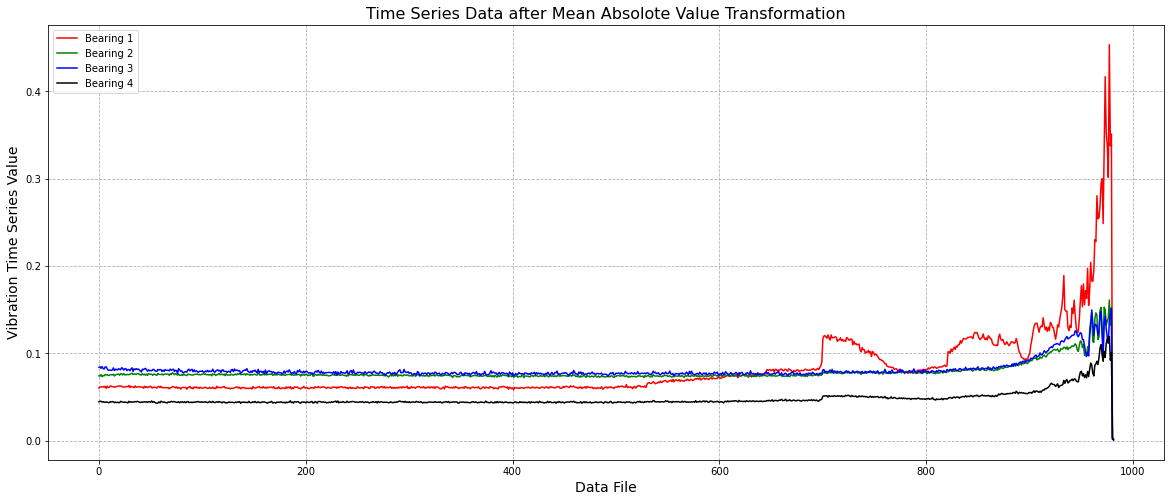

In [9]:
plt.figure(figsize=(20,8)) # Figure
plt.plot(df['B1'], label='Bearing 1', color='red') # Plot
plt.plot(df['B2'], label='Bearing 2', color='green') # Plot
plt.plot(df['B3'], label='Bearing 3', color='blue') # Plot
plt.plot(df['B4'], label='Bearing 4', color='black') # Plot
plt.legend() # Legend
plt.title('Time Series Data after Mean Absolote Value Transformation', fontdict={'fontsize':16}) # Title
plt.xlabel('Data File', fontdict={'fontsize':14}) # X-Label
plt.ylabel('Vibration Time Series Value', fontdict={'fontsize':14}) # Y-Label
plt.grid(True, linestyle='--') # Grid
plt.show() # Show

### Normalize Data

In [10]:
label_train = 'B1' # Train Label
label_test = 'B2' # Test Label

In [11]:
train = np.array(df[[label_train]]) # Train Data
test = np.array(df[[label_test]]) # Test Data

In [12]:
train = ((train - np.max(train)) + (train - np.min(train)))/(np.max(train)-np.min(train)) # Normalize
test = ((test - np.max(test)) + (test- np.min(test)))/(np.max(test)-np.min(test)) # Normalize

### Transfrom Data to LSTM Format

In [13]:
def transform(x, y, seq_size=1):
    '''Transform into LSTM accepctabel Dataset.
       Pass: Features, Labels, sequence size.
       Return: 2 arrays.'''
    x_values = [] # Empty list
    y_values = [] # Empty list
    for i in range(len(x)-seq_size): # Loop if series is 1,2,3,4 and sequence size is 3
        x_values.append(x[i:i+seq_size]) # X values 1,2,3
        y_values.append(y[i+seq_size])   # Y values 4
    return np.array(x_values), np.array(y_values) # Return 

In [14]:
seq_size = 30 # Sequence Size
trainX, trainY = transform(train, np.array(df[label_train]), seq_size=seq_size) # Train Data
testX, testY = transform(test, np.array(df[label_test]), seq_size=seq_size) # Test Data

In [15]:
print('Train X and Train Y shape:', trainX.shape, '&', trainY.shape) # Print Shape

Train X and Train Y shape: (952, 30, 1) & (952,)


### LSTM Autoencoder Model 1


In [16]:
model1 = tf.keras.Sequential(name='LSTM_Autoencoder_1') # Sequential Model
model1.add(tf.keras.layers.LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True, name='LSTM_1')) # LSTM layer 1
model1.add(tf.keras.layers.Dropout(0.2, name='Dropout_1')) # Dropout
model1.add(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True, name='LSTM_2')) # LSTM layer 2
model1.add(tf.keras.layers.Dropout(0.2, name='Dropout_2')) # Dropout
model1.add(tf.keras.layers.LSTM(16, activation='relu', return_sequences=False, name='LSTM_3')) # LSTM layer 2
model1.add(tf.keras.layers.RepeatVector(trainX.shape[1], name='Repeat_Vector')) # Repeat Vector
model1.add(tf.keras.layers.LSTM(16, activation='relu', return_sequences=True, name='LSTM_4')) # LSTM layer 2
model1.add(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True, name='LSTM_5')) # LSTM layer 3
model1.add(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True, name='LSTM_6')) # LSTM layer 4
model1.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(trainX.shape[2], name='TD_output'))) # Output
model1.compile(optimizer='adam', loss='mae') # Compile
model1.summary() # Summarize

Model: "LSTM_Autoencoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (LSTM)                (None, 30, 64)            16896     
_________________________________________________________________
Dropout_1 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
LSTM_2 (LSTM)                (None, 30, 32)            12416     
_________________________________________________________________
Dropout_2 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
LSTM_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
Repeat_Vector (RepeatVector) (None, 30, 16)            0         
_________________________________________________________________
LSTM_4 (LSTM)                (None, 30, 16)     

### LSTM Autoencoder Model 2

In [17]:
model2 = tf.keras.Sequential(name='LSTM_Autoencoder_2') # Sequential Model
model2.add(tf.keras.layers.LSTM(32, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True, name='LSTM_1')) # LSTM layer 1
model2.add(tf.keras.layers.LSTM(16, activation='relu', return_sequences=False, name='LSTM_2')) # LSTM layer 2
model2.add(tf.keras.layers.RepeatVector(trainX.shape[1], name='Repeat_Vector')) # Repeat Vector
model2.add(tf.keras.layers.LSTM(16, activation='relu', return_sequences=True, name='LSTM_3')) # LSTM layer 3
model2.add(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True, name='LSTM_4')) # LSTM layer 4
model2.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(trainX.shape[2], name='TD_output'))) # Output
model2.compile(optimizer='adam', loss='mae') # Compile
model2.summary() # Summarize

Model: "LSTM_Autoencoder_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (LSTM)                (None, 30, 32)            4352      
_________________________________________________________________
LSTM_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
Repeat_Vector (RepeatVector) (None, 30, 16)            0         
_________________________________________________________________
LSTM_3 (LSTM)                (None, 30, 16)            2112      
_________________________________________________________________
LSTM_4 (LSTM)                (None, 30, 32)            6272      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 1)             33        
Total params: 15,905
Trainable params: 15,905
Non-trainable params: 0
____________________________________________

### LSTM Autoencoder Model 3

In [18]:
model3 = tf.keras.Sequential(name='LSTM_Autoencoder_3') # Sequential Model
model3.add(tf.keras.layers.LSTM(16, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False, name='LSTM_1')) # LSTM layer 1
model3.add(tf.keras.layers.RepeatVector(trainX.shape[1], name='Repeat_Vector')) # Repeat Vector
model3.add(tf.keras.layers.LSTM(16, activation='relu', return_sequences=True, name='LSTM_2')) # LSTM layer 4
model3.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(trainX.shape[2], name='TD_output'))) # Output
model3.compile(optimizer='adam', loss='mae') # Compile
model3.summary() # Summarize

Model: "LSTM_Autoencoder_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (LSTM)                (None, 16)                1152      
_________________________________________________________________
Repeat_Vector (RepeatVector) (None, 30, 16)            0         
_________________________________________________________________
LSTM_2 (LSTM)                (None, 30, 16)            2112      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 1)             17        
Total params: 3,281
Trainable params: 3,281
Non-trainable params: 0
_________________________________________________________________


### Train Model

#### Fit Model 1

In [19]:
epochs = 20 # Epochs
history1 = model1.fit(trainX, trainY, epochs=epochs, batch_size=32, validation_split=0.1, verbose=1) # Fit Model

Epoch 1/20
27/27 [==============================] - 8s 86ms/step - loss: 0.0288 - val_loss: 0.1010
Epoch 2/20
27/27 [==============================] - 1s 55ms/step - loss: 0.0148 - val_loss: 0.1051
Epoch 3/20
27/27 [==============================] - 1s 54ms/step - loss: 0.0134 - val_loss: 0.1011
Epoch 4/20
27/27 [==============================] - 1s 55ms/step - loss: 0.0129 - val_loss: 0.0992
Epoch 5/20
27/27 [==============================] - 1s 53ms/step - loss: 0.0126 - val_loss: 0.0992
Epoch 6/20
27/27 [==============================] - 1s 53ms/step - loss: 0.0123 - val_loss: 0.0947
Epoch 7/20
27/27 [==============================] - 1s 53ms/step - loss: 0.0117 - val_loss: 0.0905
Epoch 8/20
27/27 [==============================] - 1s 53ms/step - loss: 0.0087 - val_loss: 0.0633
Epoch 9/20
27/27 [==============================] - 1s 52ms/step - loss: 0.0069 - val_loss: 0.0603
Epoch 10/20
27/27 [==============================] - 1s 53ms/step - loss: 0.0066 - val_loss: 0.0647
Epoch 11/

#### Fit Model 2

In [20]:
epochs = 20 # Epochs
history2 = model2.fit(trainX, trainY, epochs=epochs, batch_size=32, validation_split=0.1, verbose=1) # Fit Model

Epoch 1/20
27/27 [==============================] - 5s 48ms/step - loss: 0.0290 - val_loss: 0.1122
Epoch 2/20
27/27 [==============================] - 1s 30ms/step - loss: 0.0155 - val_loss: 0.1055
Epoch 3/20
27/27 [==============================] - 1s 30ms/step - loss: 0.0135 - val_loss: 0.1036
Epoch 4/20
27/27 [==============================] - 1s 30ms/step - loss: 0.0133 - val_loss: 0.1000
Epoch 5/20
27/27 [==============================] - 1s 30ms/step - loss: 0.0127 - val_loss: 0.1018
Epoch 6/20
27/27 [==============================] - 1s 30ms/step - loss: 0.0125 - val_loss: 0.0998
Epoch 7/20
27/27 [==============================] - 1s 30ms/step - loss: 0.0117 - val_loss: 0.0935
Epoch 8/20
27/27 [==============================] - 1s 30ms/step - loss: 0.0105 - val_loss: 0.0770
Epoch 9/20
27/27 [==============================] - 1s 30ms/step - loss: 0.0055 - val_loss: 0.0604
Epoch 10/20
27/27 [==============================] - 1s 30ms/step - loss: 0.0049 - val_loss: 0.0589
Epoch 11/

#### Fit Model 3

In [21]:
epochs = 20 # Epochs
history3 = model3.fit(trainX, trainY, epochs=epochs, batch_size=32, validation_split=0.1, verbose=1) # Fit Model

Epoch 1/20
27/27 [==============================] - 3s 24ms/step - loss: 0.0363 - val_loss: 0.1109
Epoch 2/20
27/27 [==============================] - 0s 14ms/step - loss: 0.0177 - val_loss: 0.1103
Epoch 3/20
27/27 [==============================] - 0s 14ms/step - loss: 0.0160 - val_loss: 0.1135
Epoch 4/20
27/27 [==============================] - 0s 14ms/step - loss: 0.0148 - val_loss: 0.1080
Epoch 5/20
27/27 [==============================] - 0s 14ms/step - loss: 0.0136 - val_loss: 0.1041
Epoch 6/20
27/27 [==============================] - 0s 14ms/step - loss: 0.0122 - val_loss: 0.0969
Epoch 7/20
27/27 [==============================] - 0s 14ms/step - loss: 0.0101 - val_loss: 0.0790
Epoch 8/20
27/27 [==============================] - 0s 14ms/step - loss: 0.0062 - val_loss: 0.0515
Epoch 9/20
27/27 [==============================] - 0s 14ms/step - loss: 0.0036 - val_loss: 0.0521
Epoch 10/20
27/27 [==============================] - 0s 14ms/step - loss: 0.0032 - val_loss: 0.0501
Epoch 11/

#### Plot Losses

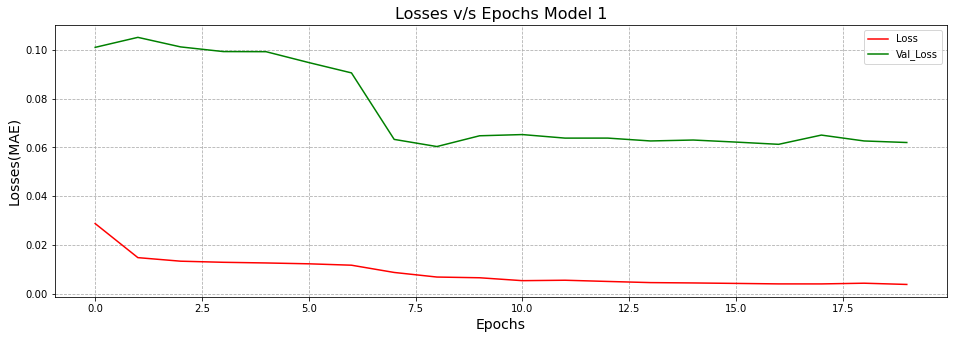

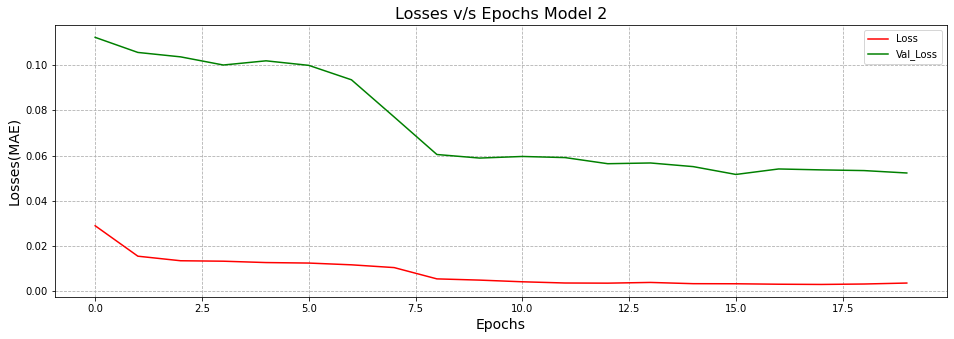

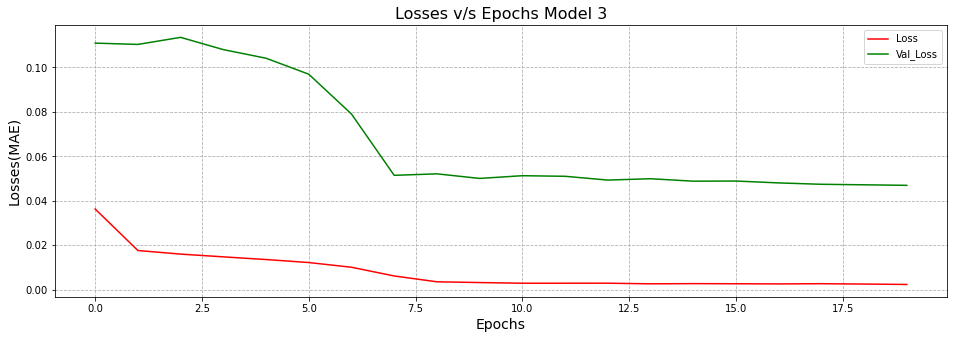

In [22]:
def plot(history, string, s):
    '''Plots Losses'''
    plt.figure(figsize=(16,5)) # Figure
    plt.plot(history.history[string], color='red', label=string.capitalize()) # Plot
    plt.plot(history.history['val_'+string], color='green', label='Val_'+string.capitalize()) # Plot
    plt.title('Losses v/s Epochs'+' '+s, fontdict={'fontsize':16}) # Title
    plt.xlabel('Epochs', fontdict={'fontsize':14}) # X-Label
    plt.ylabel('Losses(MAE)', fontdict={'fontsize':14}) # Y-Label
    plt.legend() # Legend
    plt.grid(True, linestyle='--') # Grid
    plt.show() # Show

# Call
plot(history1, 'loss', 'Model 1') # Model 1
plot(history2, 'loss', 'Model 2') # Model 2
plot(history3, 'loss', 'Model 3') # Model 3

### Analysis

#### Evaluate Model 1

In [23]:
performance1 = model1.evaluate(testX, testY, verbose=1) # Evaluate
print('Losses Evaluation of Test set-Model 1:', np.around(performance1,5)) # Print Performance

30/30 [==============================] - 1s 17ms/step - loss: 0.0331
Losses Evaluation of Test set-Model 1: 0.03315


#### Evaluate Model 2

In [24]:
performance2 = model2.evaluate(testX, testY, verbose=1) # Evaluate
print('Losses Evaluation of Test set-Model 2:', np.around(performance2,5)) # Print Performance

30/30 [==============================] - 1s 9ms/step - loss: 0.0521
Losses Evaluation of Test set-Model 2: 0.05208


#### Evaluate Model 3

In [25]:
performance3 = model3.evaluate(testX, testY, verbose=1) # Evaluate
print('Losses Evaluation of Test set-Model 3:', np.around(performance3,5)) # Print Performance

30/30 [==============================] - 0s 4ms/step - loss: 0.0705
Losses Evaluation of Test set-Model 3: 0.07049


#### Predict Model 1

In [26]:
y_pred1 = model1.predict(testX, verbose=1) # Predict
test_loss1 = np.mean(np.abs(y_pred1 - testX), axis=1) # Get difference in losse

30/30 [==============================] - 1s 16ms/step


#### Predict Model 2

In [27]:
y_pred2 = model2.predict(testX, verbose=1) # Predict
test_loss2 = np.mean(np.abs(y_pred2 - testX), axis=1) # Get difference in losse

30/30 [==============================] - 1s 8ms/step


#### Predict Model 3

In [28]:
y_pred3 = model3.predict(testX, verbose=1) # Predict
test_loss3 = np.mean(np.abs(y_pred3 - testX), axis=1) # Get difference in losse

30/30 [==============================] - 0s 4ms/step


### Plot Loss Distribution

In [29]:
def plot_loss_distribution(test_loss, st):
    '''Plots Loss DIstribution.
       Pass: Test Loss and Model Name'''
    plt.figure(figsize=(18,7), dpi=100) # Figure
    sns.histplot(test_loss, bins=100, kde=True, legend=False) # Histogram
    plt.title('Loss Distrbution '+st, fontdict={'fontsize':16}) # Title
    plt.xlabel('Loss', fontdict={'fontsize':14}) # X-Label
    plt.ylabel('Density', fontdict={'fontsize':14}) # Y-Label
    plt.grid(True, linestyle='--') # Grids
    plt.show() # Show
    return None

#### Model 1

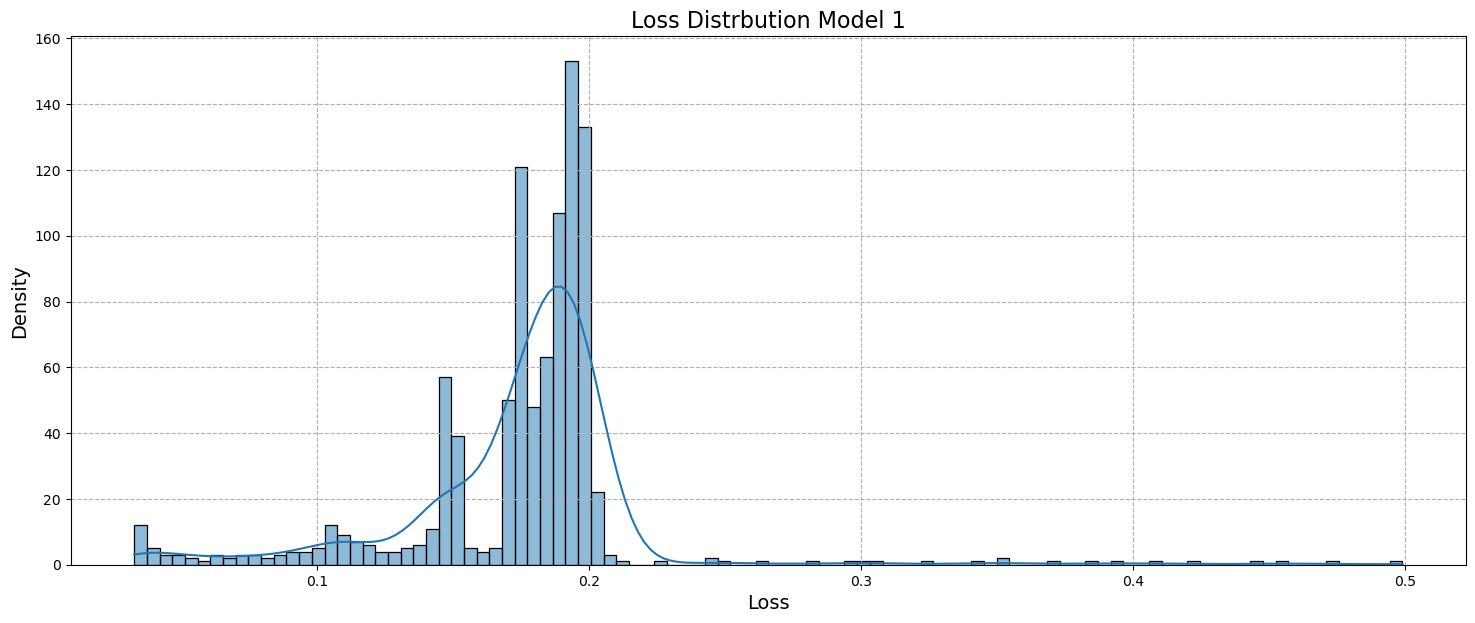

In [30]:
plot_loss_distribution(test_loss1, 'Model 1') # Model 1

#### Model 2

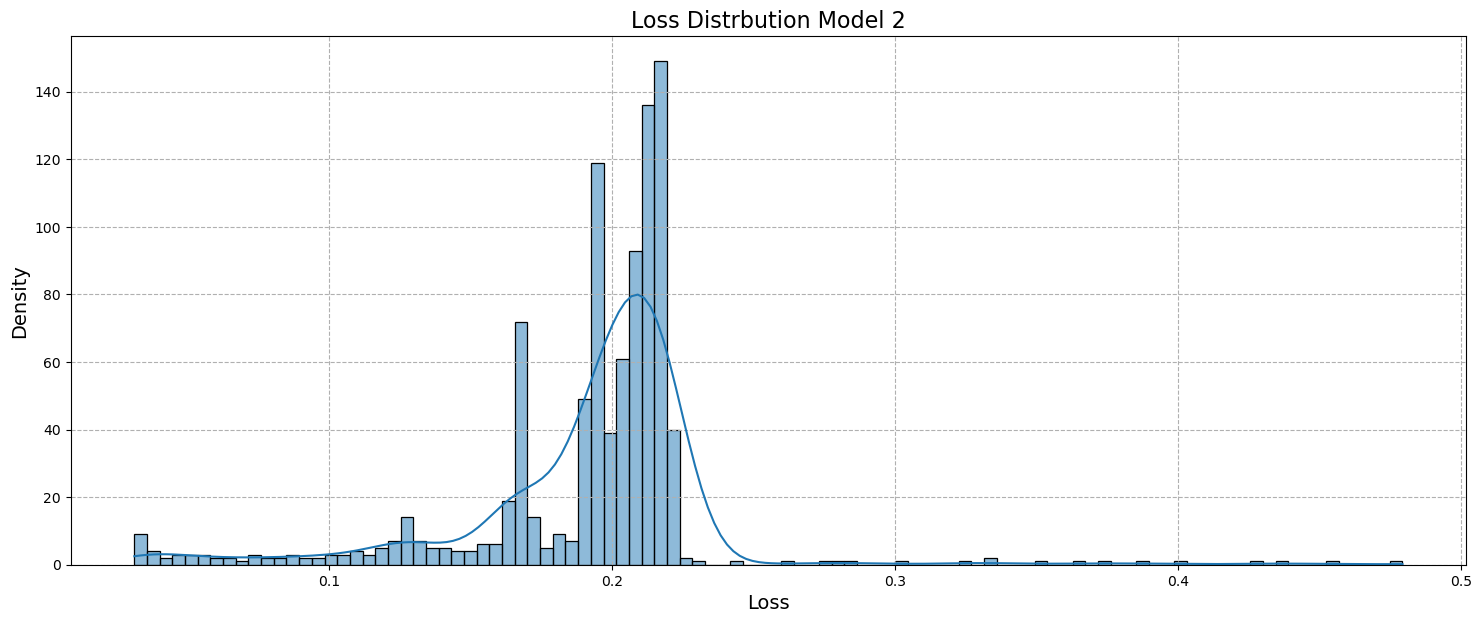

In [31]:
plot_loss_distribution(test_loss2, 'Model 2') # Model 2

#### Model 3

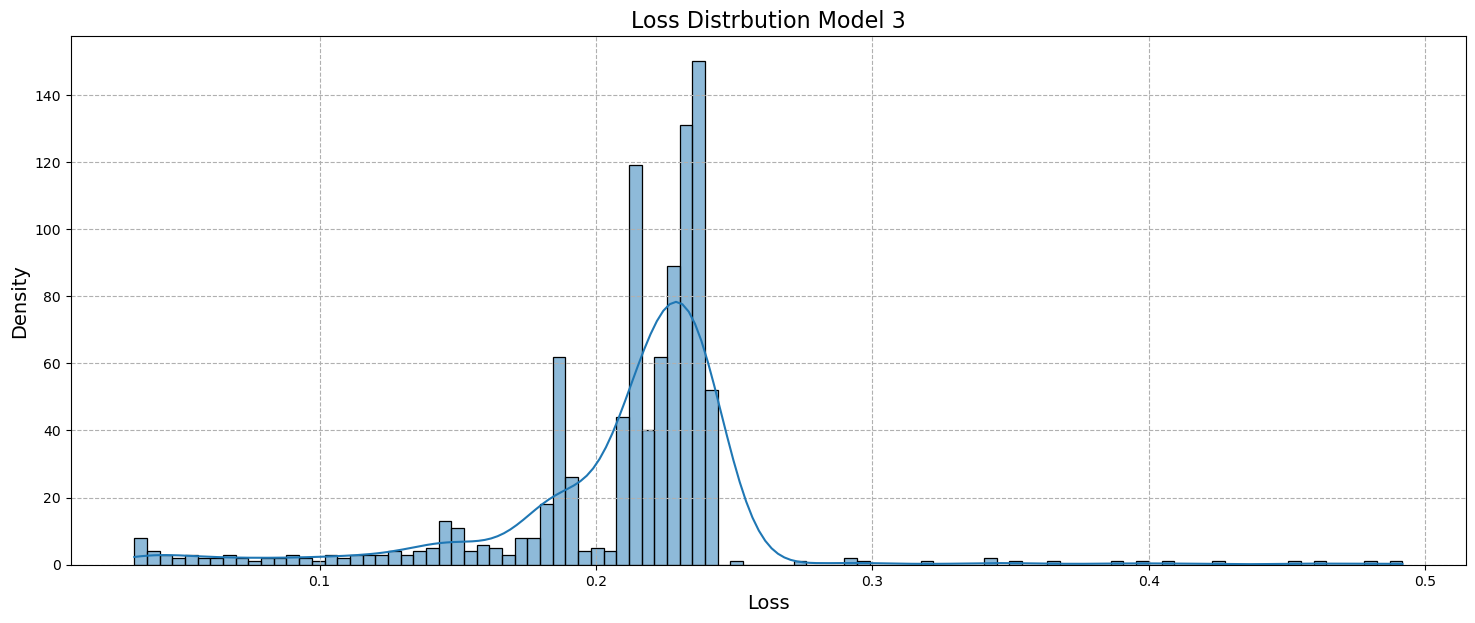

In [32]:
plot_loss_distribution(test_loss3, 'Model 3') # Model 3

#### Note:
        Set any value of Loss above a threshold as an anomaly.

### Plot Anomaly

In [33]:
def anamoly(test_loss, st, anamoly_val):
    '''Plots Anamolies above a loss threshold.
       Pass: Test Loss, Model Name, Threshold value.
       Return: 2 Dataframes '''
    anamoly_df = pd.DataFrame(df[label_test][seq_size:]) # Dataframe
    anamoly_df['Loss'] = test_loss # Loss b/w Actual and Predicted
    anamoly_df['Threshold'] = anamoly_val # Threshold Loss
    anamoly_df['Anamoly'] = anamoly_df['Loss'] > anamoly_df['Threshold'] # Anamoly is True or False
    
    plt.figure(figsize=(16,6)) # Figure
    plt.plot(anamoly_df['Loss'], linewidth=1, color='green', label='Loss') # Plot
    plt.plot(anamoly_df['Threshold'], linewidth=2, linestyle='--', color='red', label='Threshold') # Plot
    plt.grid(True, color='black', linestyle='--') # Grid
    plt.legend(fontsize=10, title='Legend', loc=0, edgecolor='black', title_fontsize=12) # Legend
    plt.title('File Number v/s Loss '+st, fontdict={'fontsize':16}) # Title
    plt.xlabel('File number', fontdict={'fontsize':14}) # X-Label
    plt.ylabel('Loss MAE', fontdict={'fontsize':14}) # Y-Label
    plt.show()# Show
    
    anamolies = anamoly_df.loc[anamoly_df['Anamoly'] == True] # Dataframe with info where anamoly is true
    index = np.array(anamolies.index) # Get Index Names
    anamolies.head() # Peek
    
    plt.figure(figsize=(16,6))  # Figure
    plt.plot(anamoly_df['Loss'], color ='green', linewidth=2) # Plot 
    plt.scatter(index, anamolies['Loss'], s=36, color='black', label='Anomaly') # Scatter
    plt.grid(True, color='black', linestyle='--') # Grid
    plt.title('File Number v/s Loss '+st, fontdict={'fontsize':16, 'fontweight':'semibold'}) # Title
    plt.xlabel('File number', fontdict={'fontsize':14, 'fontweight':'semibold'}) # X-Label
    plt.ylabel('Loss MAE', fontdict={'fontsize':14, 'fontweight':'semibold'}) # Y-Label
    plt.legend(fontsize=10, title='Legend', loc=0, edgecolor='black', title_fontsize=12) # Legend
    plt.show()# Show
    
    return anamoly_df, anamolies # return dataframes

#### Model 1

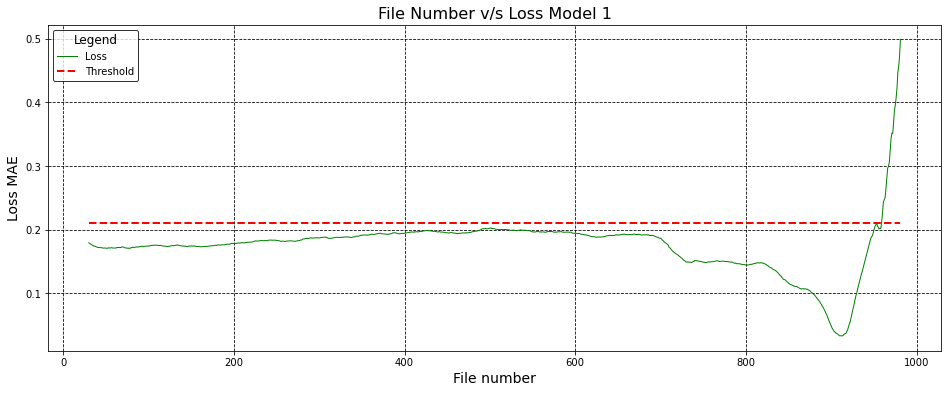

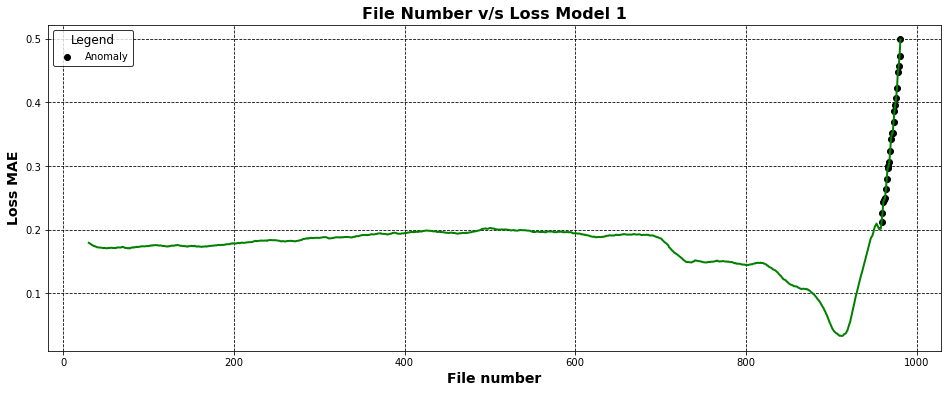

In [40]:
anamoly_df1, anamolies1 = anamoly(test_loss1, 'Model 1', anamoly_val=0.21)

#### Model 2

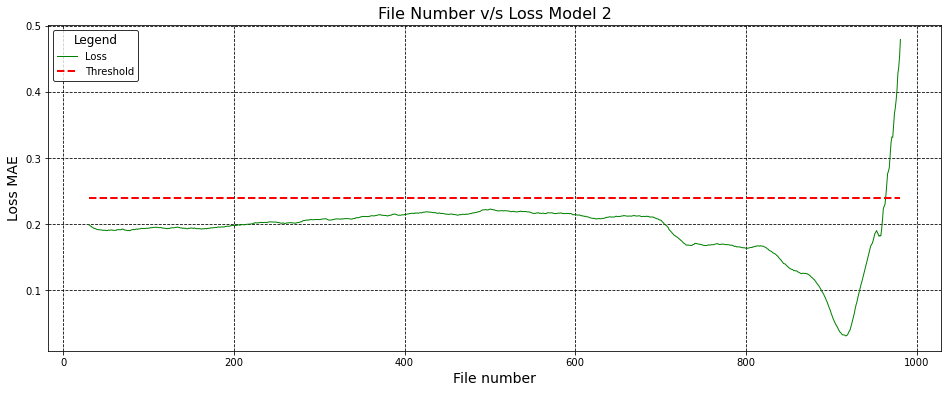

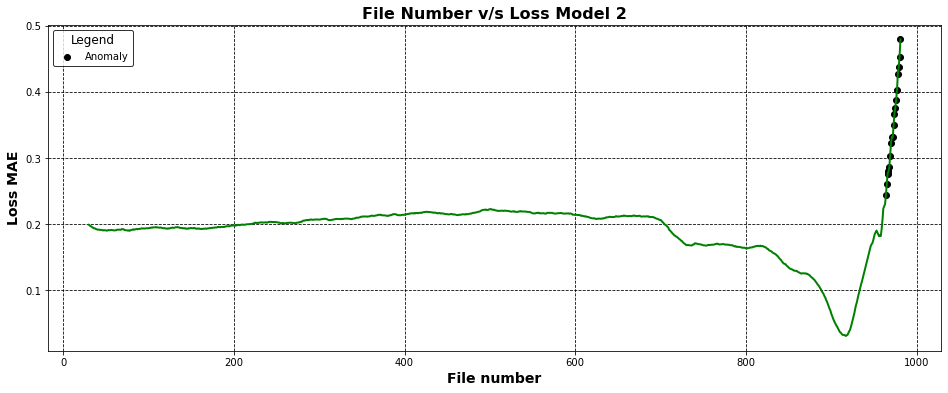

In [38]:
anamoly_df2, anamolies2 = anamoly(test_loss2, 'Model 2', anamoly_val=0.24)

#### Model 3

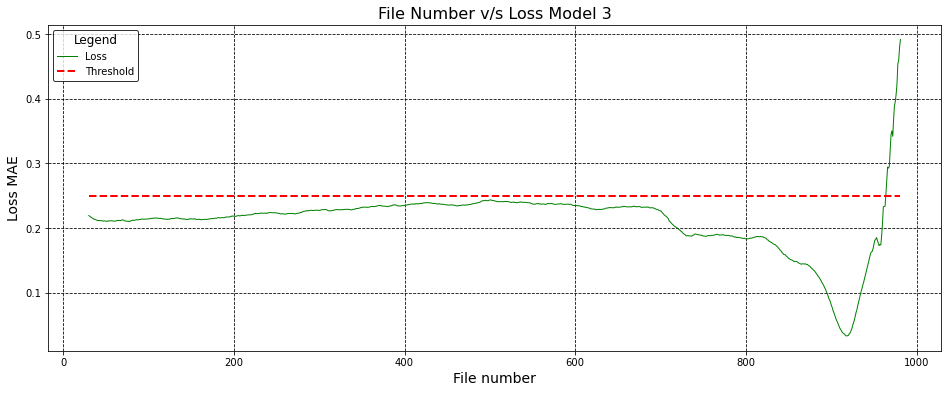

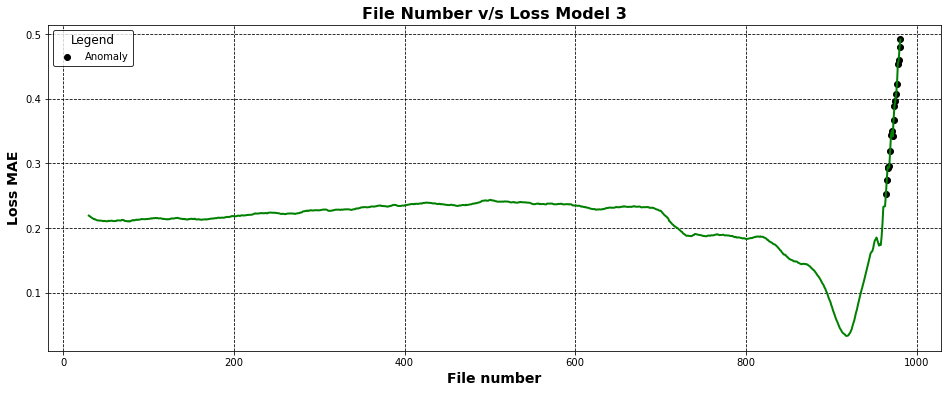

In [39]:
anamoly_df3, anamolies3 = anamoly(test_loss3, 'Model 3', anamoly_val=0.25)